In [16]:
# Test fe18 stuff with the different degradation factors
# 
# This time trying with an Apr 2019 example
# 
# 16-Sep-2020 IGH

In [17]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u

import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Let's get the degradation correction factors for v8 and v9
channels = [94, 171, 211] * u.angstrom
time=atime.Time('2019-04-25T22:45:00', scale='utc')
print(channels)
print(time.isot)

[ 94. 171. 211.] Angstrom
2019-04-25T22:45:00.000


In [19]:
# # Need to manually pull out the v8 and v9 version
# nc=len(channels)
# degs8=np.empty(nc)
# degs9=np.empty(nc)
# # Bit slow but cant see how to do this via the calibration tables
# for i in np.arange(nc):
#     degs8[i]=degradation(channels[i],time,calibration_version=8)
#     degs9[i]=degradation(channels[i],time,calibration_version=9)
# print(degs8,degs9)

[0.74183735 0.74738639 0.685066  ] [0.96042037 0.74981398 0.5004412 ]


In [20]:
# Just have the numbers here manually as faster the next time and can above above cell
# Sep 2018 values
# degs8=np.array([0.74183735, 0.75479493, 0.69658929])
# degs9=np.array([0.93609983,0.73458129,0.5770613 ])
# Feb 2020 values needed here:
# degs8=np.array([0.74183735,0.73760064,0.66984516])
# degs9=np.array([0.99254478,0.76993447,0.4475236 ])
# Apr 2019 values needed here:
degs8=np.array([0.74183735, 0.74738639, 0.685066])
degs9=np.array([0.96042037, 0.74981398, 0.5004412 ])

print(degs8,degs9)

[0.74183735 0.74738639 0.685066  ] [0.96042037 0.74981398 0.5004412 ]


In [21]:
# Now load in the fits files
fdir='/Users/iain/Downloads/' 
# The 171 & 211 are at roughly the same time, the 94 either 10s before or 2s after
# f094=fdir+'aia.lev1.94A_2019-04-25T22_45_23.12Z.image_lev1.fits'
f094=fdir+'aia.lev1.94A_2019-04-25T22_45_35.12Z.image_lev1.fits'
f171=fdir+'aia.lev1.171A_2019-04-25T22_45_33.35Z.image_lev1.fits'
f211=fdir+'aia.lev1.211A_2019-04-25T22_45_33.63Z.image_lev1.fits'
fname='20190425'

In [24]:
m094 = sunpy.map.Map(f094)
bl=[730,-80]*u.arcsec
tr=[880,70]*u.arcsec
m094_updated_pointing = update_pointing(m094)
m094_reg = register(m094_updated_pointing)
bottom_left = SkyCoord(bl[0],bl[1], frame=m094_reg.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=m094_reg.coordinate_frame)
m094_smap = m094_reg.submap(bottom_left, top_right=top_right)
m094_smap.save(fdir+'a094_'+fname+'_submap.fits',overwrite='True')

m171 = sunpy.map.Map(f171)
m171_updated_pointing = update_pointing(m171)
m171_reg = register(m171_updated_pointing)
bottom_left = SkyCoord(bl[0],bl[1], frame=m171_reg.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=m171_reg.coordinate_frame)
m171_smap = m171_reg.submap(bottom_left, top_right=top_right)
m171_smap.save(fdir+'a171_'+fname+'_submap.fits',overwrite='True')

m211 = sunpy.map.Map(f211)
m211_updated_pointing = update_pointing(m211)
m211_reg = register(m211_updated_pointing)
bottom_left = SkyCoord(bl[0],bl[1],  frame=m211_reg.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], 140 * u.arcsec, frame=m211_reg.coordinate_frame)
m211_smap = m211_reg.submap(bottom_left, top_right=top_right)
m211_smap.save(fdir+'a211_'+fname+'_submap.fits',overwrite='True')


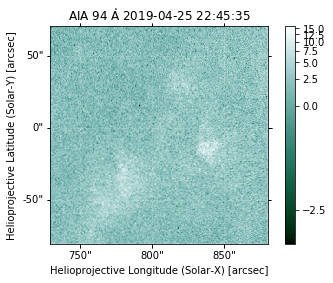

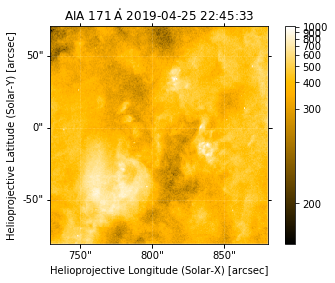

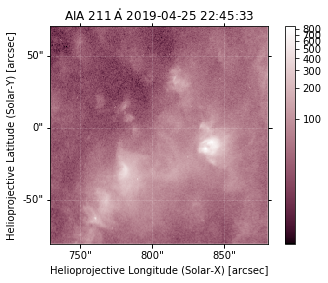

In [25]:
# Load back in the submaps and check look ok
mp094=sunpy.map.Map(fdir+'a094_'+fname+'_submap.fits')
mp171=sunpy.map.Map(fdir+'a171_'+fname+'_submap.fits')
mp211=sunpy.map.Map(fdir+'a211_'+fname+'_submap.fits')

mp094.peek()
mp171.peek()
mp211.peek()


In [26]:
# Extract the data from the maps
data094=mp094.data/mp094.exposure_time.value
data171=mp171.data/mp171.exposure_time.value
data211=mp211.data/mp211.exposure_time.value
data094[data094 <0] = 0
data171[data171 <0] = 0
data211[data211 <0] = 0

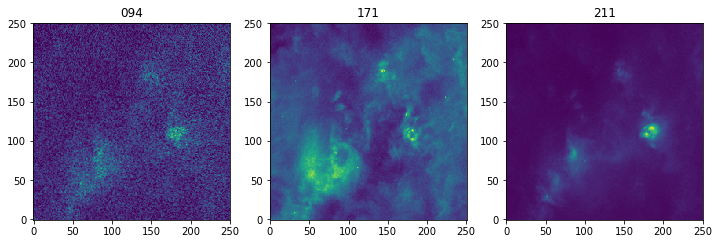

In [27]:
fig, ax = plt.subplots(1, 3,figsize=(12, 4))
ax[0].imshow(data094,origin='lower')
ax[0].set_title('094')
ax[1].imshow(data171,origin='lower')
ax[1].set_title('171')
ax[2].imshow(data211,origin='lower')
ax[2].set_title('211')
plt.show()

In [28]:
# Make the degradation corrections
data094v8=data094/degs8[0]
data171v8=data171/degs8[1]
data211v8=data211/degs8[2]

data094v9=data094/degs9[0]
data171v9=data171/degs9[1]
data211v9=data211/degs9[2]

In [29]:
# Work out the Fe18
datafe18v8=data094v8 - data171v8/450. - data211v8/211.
datafe18v8[datafe18v8 < 0]=0
datafe18v9=data094v9 - data171v9/450. - data211v9/211.
datafe18v9[datafe18v9 < 0]=0
print(np.max(datafe18v8),np.max(datafe18v9))
print(np.min(datafe18v8[datafe18v8 >0]),np.min(datafe18v9[datafe18v9 >0]))

5.109913083527153 3.434192197930356
5.304294764280071e-06 7.970545878310809e-07


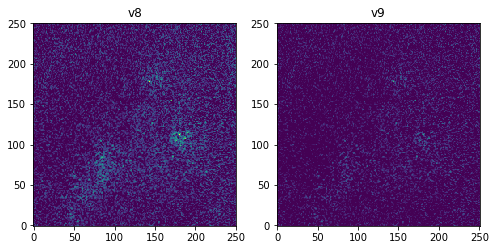

In [32]:
fig, ax = plt.subplots(1, 2,figsize=(8, 4))
ax[0].imshow(datafe18v8,origin='lower',norm=colors.Normalize(vmin=0.01,vmax=5))
ax[0].set_title('v8')
ax[1].imshow(datafe18v9,origin='lower',norm=colors.Normalize(vmin=0.01,vmax=5))
ax[1].set_title('v9')
plt.show()

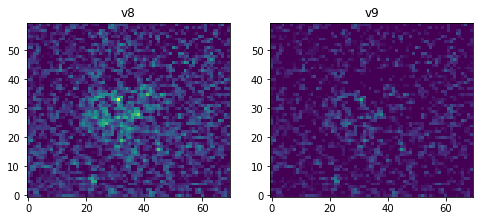

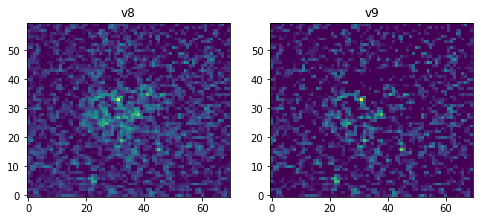

In [34]:
loopv8=datafe18v8[80:140,150:220]
loopv9=datafe18v9[80:140,150:220]
fig, ax = plt.subplots(1, 2,figsize=(8, 4))
ax[0].imshow(loopv8,origin='lower',norm=colors.Normalize(vmin=0.01,vmax=5))
ax[0].set_title('v8')
ax[1].imshow(loopv9,origin='lower',norm=colors.Normalize(vmin=0.01,vmax=5))
ax[1].set_title('v9')
plt.show()


fig, ax = plt.subplots(1, 2,figsize=(8, 4))
ax[0].imshow(loopv8,origin='lower',\
             norm=colors.Normalize(vmin=np.min(loopv8[loopv8>0]),vmax=np.max(loopv8)))
ax[0].set_title('v8')
ax[1].imshow(loopv9,origin='lower',\
             norm=colors.Normalize(vmin=np.min(loopv9[loopv9>0]),vmax=np.max(loopv9)))
ax[1].set_title('v9')
plt.show()

In [35]:
print('<v8 DN/s/px>: ',np.mean(loopv8))
print('<v9 DN/s/px>: ',np.mean(loopv9))
print('Ratio: ',np.mean(loopv8)/np.mean(loopv9))

print('<v8 non-0 DN/s/px>: ',np.mean(loopv8[loopv8 >0]))
print('<v9 non-0 DN/s/px>: ',np.mean(loopv9[loopv9 >0]))
print('Ratio non-0: ',np.mean(loopv8[loopv8 >0])/np.mean(loopv9[loopv9 >0]))

<v8 DN/s/px>:  0.6432625850482843
<v9 DN/s/px>:  0.25167537543083196
Ratio:  2.5559218256736935
<v8 non-0 DN/s/px>:  0.8179542407516784
<v9 non-0 DN/s/px>:  0.4611852429360795
Ratio non-0:  1.773591530258585
